In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

* NAME: Rishabh Patil
* SAP: 60009200056
* BATCH: D12

Library Loading

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import os
import gc
import cv2
import json
import math
import scipy
import itertools
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras import layers
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten,BatchNormalization
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tqdm import tqdm
from keras import backend as K
from functools import partial
from collections import Counter

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Augmentation and Dataset Loading

In [3]:
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
)

BATCH_SIZE = 16

def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

# Loading the Data

Paratisized Cells

100%|██████████| 13780/13780 [01:28<00:00, 155.40it/s]


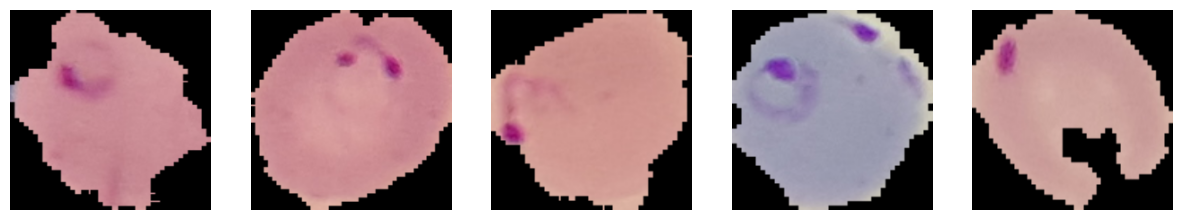

In [4]:
dataset_B = Dataset_loader('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized',224)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(dataset_B[i])
    axes[i].axis('off')
plt.show()

Uninfected Cells

100%|██████████| 13780/13780 [01:25<00:00, 161.50it/s]


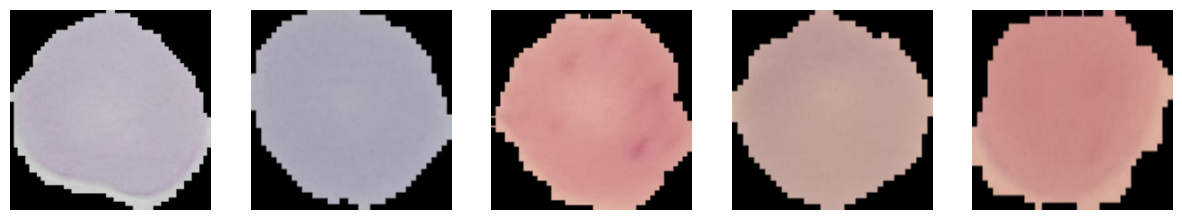

In [5]:
dataset_M = Dataset_loader('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected',224)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(dataset_M[i])
    axes[i].axis('off')
plt.show()

Dataset Split

In [6]:
# Split the datasets into training and testing sets
train_data_parasitized = np.array(dataset_B[:400])
test_data_parasitized = np.array(dataset_B[401:800])
train_data_uninfected = np.array(dataset_M[:400])
test_data_uninfected = np.array(dataset_M[401:800])

Data Processing

In [7]:
# Create labels
parasitized_train_label = np.ones(len(train_data_parasitized))
uninfected_train_label = np.zeros(len(train_data_uninfected))
parasitized_test_label = np.ones(len(test_data_parasitized))
uninfected_test_label = np.zeros(len(test_data_uninfected))
label =  {0:"uninfected",1:"parasitized"}

# Merge data
X_train = np.concatenate((train_data_parasitized, train_data_uninfected), axis = 0)
Y_train = np.concatenate((parasitized_train_label, uninfected_train_label), axis = 0)
X_test = np.concatenate((test_data_parasitized, test_data_uninfected), axis = 0)
Y_test = np.concatenate((parasitized_test_label, uninfected_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

CNN Model

In [44]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding="valid", activation="relu", input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)


Model Execution

In [45]:
CNN_history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs= 4,
    validation_data=(x_val, y_val))

Epoch 1/4
40/40 [==============================] - 10s 224ms/step - loss: 6.4025 - accuracy: 0.5672 - val_loss: 5.2190 - val_accuracy: 0.5688
Epoch 2/4
40/40 [==============================] - 8s 203ms/step - loss: 5.1668 - accuracy: 0.5562 - val_loss: 15.8491 - val_accuracy: 0.4938
Epoch 3/4
40/40 [==============================] - 8s 200ms/step - loss: 4.5468 - accuracy: 0.5625 - val_loss: 9.0350 - val_accuracy: 0.5250
Epoch 4/4
40/40 [==============================] - 9s 224ms/step - loss: 5.0433 - accuracy: 0.5437 - val_loss: 5.1971 - val_accuracy: 0.5125


In [46]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 222, 222, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 220, 220, 32)      4640      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 220, 220, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 218, 218, 64)      18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 218, 218, 64)    

# Hyperparameter Tuning

Epochs

In [ ]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs= 2,
    validation_data=(x_val, y_val))

Reduce Overfitting by early stopping callback

In [13]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [14]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs= 4,
    validation_data=(x_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/4
40/40 [==============================] - 9s 227ms/step - loss: 5.1331 - accuracy: 0.5766 - val_loss: 3.8217 - val_accuracy: 0.6438
Epoch 2/4
40/40 [==============================] - 8s 206ms/step - loss: 5.6271 - accuracy: 0.5578 - val_loss: 2.2856 - val_accuracy: 0.6562
Epoch 3/4
40/40 [==============================] - 8s 202ms/step - loss: 5.7100 - accuracy: 0.5625 - val_loss: 5.4242 - val_accuracy: 0.6125
Epoch 4/4
40/40 [==============================] - 9s 225ms/step - loss: 5.3550 - accuracy: 0.5281 - val_loss: 4.5050 - val_accuracy: 0.4938


Loss

In [15]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding="valid", activation="relu", input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

from keras.losses import CategoricalCrossentropy

model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 222, 222, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 220, 220, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 220, 220, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 218, 218, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 218, 218, 64)    

In [17]:
history = model.fit(
    train_generator.
    flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs= 4,
    validation_data=(x_val, y_val))

Epoch 1/4
40/40 [==============================] - 9s 209ms/step - loss: 14.8581 - accuracy: 0.5219 - val_loss: 22.4870 - val_accuracy: 0.5500
Epoch 2/4
40/40 [==============================] - 8s 207ms/step - loss: 7.7868 - accuracy: 0.5547 - val_loss: 8.5064 - val_accuracy: 0.4812
Epoch 3/4
40/40 [==============================] - 9s 229ms/step - loss: 7.8735 - accuracy: 0.5891 - val_loss: 7.0316 - val_accuracy: 0.6687
Epoch 4/4
40/40 [==============================] - 8s 206ms/step - loss: 8.7949 - accuracy: 0.5531 - val_loss: 6.5792 - val_accuracy: 0.6438


Optimizer

In [18]:
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(Conv2D(16, (3, 3), padding="valid", activation="relu", input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

optimizer = RMSprop(learning_rate=0.001)
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 222, 222, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 220, 220, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 220, 220, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 218, 218, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 218, 218, 64)    

In [20]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs= 4,
    validation_data=(x_val, y_val))

Epoch 1/4
40/40 [==============================] - 11s 202ms/step - loss: 129.3054 - accuracy: 0.5281 - val_loss: 262.5865 - val_accuracy: 0.4500
Epoch 2/4
40/40 [==============================] - 8s 198ms/step - loss: 118.1317 - accuracy: 0.5156 - val_loss: 494.6321 - val_accuracy: 0.5188
Epoch 3/4
40/40 [==============================] - 9s 220ms/step - loss: 105.3109 - accuracy: 0.5422 - val_loss: 267.1784 - val_accuracy: 0.5063
Epoch 4/4
40/40 [==============================] - 8s 201ms/step - loss: 101.0585 - accuracy: 0.5375 - val_loss: 164.3612 - val_accuracy: 0.5938


ResNet

In [8]:

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

# Load the pre-trained ResNet50 model
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in resnet.layers:
    layer.trainable = False

# Create the top layers for classification
x = resnet.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
outputs = Dense(2, activation='softmax')(x)

# Create the ResNet model
model = Model(inputs=resnet.input, outputs=outputs)

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)


94765736/94765736 [==============================] - 0s 0us/step


In [9]:
resnet_history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs= 4,
    validation_data=(x_val, y_val))

Epoch 1/4
40/40 [==============================] - 24s 273ms/step - loss: 0.7156 - accuracy: 0.6094 - val_loss: 0.5004 - val_accuracy: 0.7875
Epoch 2/4
40/40 [==============================] - 8s 210ms/step - loss: 0.5998 - accuracy: 0.7266 - val_loss: 0.4417 - val_accuracy: 0.8250
Epoch 3/4
40/40 [==============================] - 8s 207ms/step - loss: 0.5421 - accuracy: 0.7437 - val_loss: 0.4364 - val_accuracy: 0.8188
Epoch 4/4
40/40 [==============================] - 8s 209ms/step - loss: 0.5494 - accuracy: 0.7328 - val_loss: 0.3832 - val_accuracy: 0.8625


In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

MobileNet

In [10]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D
mobilenet = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))


for layer in mobilenet.layers:
    layer.trainable = False

x = mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)

# Create the MobileNet model
model = Model(inputs=mobilenet.input, outputs=outputs)

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)


17225924/17225924 [==============================] - 0s 0us/step


In [11]:
MN_history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs= 4,
    validation_data=(x_val, y_val))

Epoch 1/4
40/40 [==============================] - 11s 222ms/step - loss: 0.9462 - accuracy: 0.5016 - val_loss: 0.7738 - val_accuracy: 0.5125
Epoch 2/4
40/40 [==============================] - 7s 184ms/step - loss: 0.8706 - accuracy: 0.5500 - val_loss: 0.7718 - val_accuracy: 0.5063
Epoch 3/4
40/40 [==============================] - 7s 185ms/step - loss: 0.8756 - accuracy: 0.5234 - val_loss: 0.7613 - val_accuracy: 0.5125
Epoch 4/4
40/40 [==============================] - 8s 212ms/step - loss: 0.8922 - accuracy: 0.5297 - val_loss: 0.7709 - val_accuracy: 0.5125


In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

Graph comparison

In [51]:
from tensorflow.keras.applications import VGG16

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def build_vgg19(input_shape=(224, 224, 3), num_classes=1000):
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Create VGG-19 model
vgg19 = build_vgg19()

# Display model summary
vgg19.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_45 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_47 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                 

In [53]:
vgg19.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)


In [12]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Create VGG19 base model
vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in vgg19.layers:
    layer.trainable = False

x = vgg19.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)  # Change the number of units to match your output classes (binary: 2)

# Create the VGG19-based model
model = Model(inputs=vgg19.input, outputs=outputs)

# Compile the model
model.compile(
    loss='binary_crossentropy',  # Change the loss function if needed
    optimizer=Adam(learning_rate=1e-4),  # You can adjust the learning rate
    metrics=['accuracy']
)

# Print the model summary
model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [13]:
vgg19_history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs= 4,
    validation_data=(x_val, y_val))

Epoch 1/4
40/40 [==============================] - 17s 340ms/step - loss: 2.0924 - accuracy: 0.5437 - val_loss: 1.2524 - val_accuracy: 0.4875
Epoch 2/4
40/40 [==============================] - 10s 243ms/step - loss: 1.9799 - accuracy: 0.5312 - val_loss: 1.0238 - val_accuracy: 0.5188
Epoch 3/4
40/40 [==============================] - 9s 224ms/step - loss: 2.0407 - accuracy: 0.5594 - val_loss: 0.9484 - val_accuracy: 0.5500
Epoch 4/4
40/40 [==============================] - 9s 224ms/step - loss: 1.7868 - accuracy: 0.5734 - val_loss: 0.9114 - val_accuracy: 0.6000


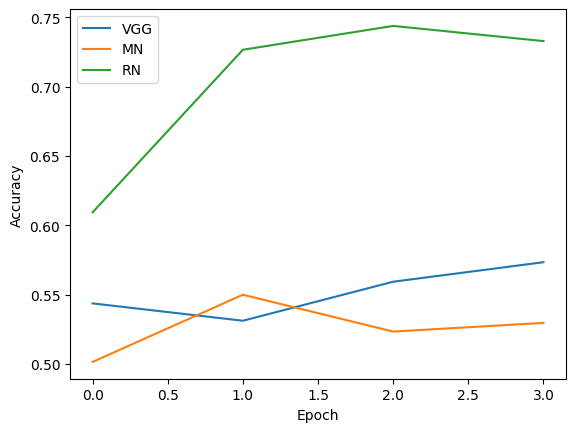

In [16]:
import matplotlib.pyplot as plt

# Assuming you have already trained the ResNet model and stored its training history in `resnet_history`

# Plot training & validation accuracy values
plt.plot(vgg19_history.history['accuracy'])
plt.plot(MN_history.history['accuracy'])
plt.plot(resnet_history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['VGG', 'MN','RN'], loc='upper left')
plt.show()